In [102]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import pydicom
from PIL import Image

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [61]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
print(len(sample_df))
sample_df.head(3)

5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168


In [62]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
print(len(all_xray_df))
all_xray_df.head(10)

112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN


In [63]:
for col in all_xray_df.columns: 
    print(col) 

Image Index
Finding Labels
Follow-up #
Patient ID
Patient Age
Patient Gender
View Position
OriginalImage[Width
Height]
OriginalImagePixelSpacing[x
y]
Unnamed: 11


### 1. Splitting "Finding Labels" into one column per desease (one hot encoding). This will help us down the line with respect to analysing the data.

In [64]:
data = all_xray_df.copy()
## EDA
# Todo 
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print(all_labels, type(all_labels), "\n")

all_labels = [x for x in all_labels if len(x)>0]
print('Labels ({}): {}, type: {}'.format(len(all_labels), all_labels, type(all_labels)))
for c_label in all_labels:
    if len(c_label)>0: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
data.head(10)

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax'] <class 'numpy.ndarray'> 

Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'], type: <class 'list'>


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0,0,1,0,0,0,0,0,0,0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0,0,1,1,0,0,0,0,0,0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [65]:
for col in data.columns: 
    print(col) 

Image Index
Finding Labels
Follow-up #
Patient ID
Patient Age
Patient Gender
View Position
OriginalImage[Width
Height]
OriginalImagePixelSpacing[x
y]
Unnamed: 11
Atelectasis
Cardiomegaly
Consolidation
Edema
Effusion
Emphysema
Fibrosis
Hernia
Infiltration
Mass
No Finding
Nodule
Pleural_Thickening
Pneumonia
Pneumothorax


## Distribution of data (with Pneumonia) with respect to age:

112120


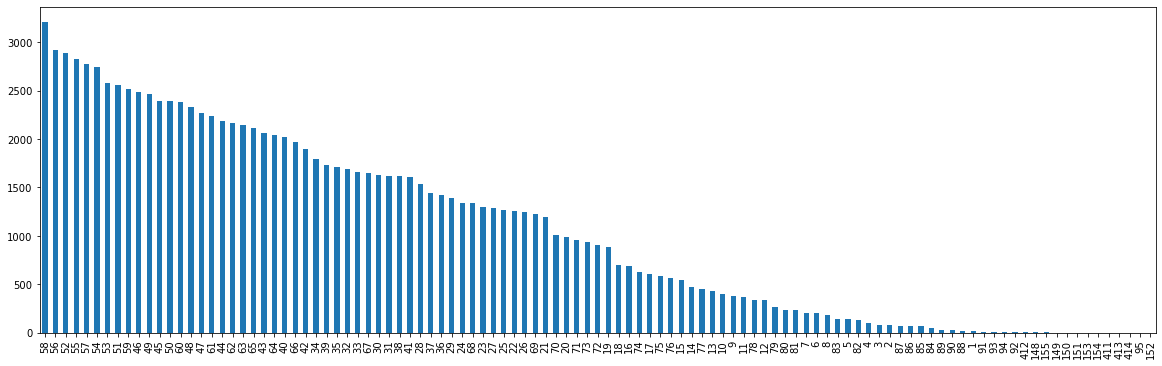

In [66]:
# Age distribution
plt.figure(figsize=(20,6))
data['Patient Age'].value_counts().plot(kind='bar')
print(len(data))

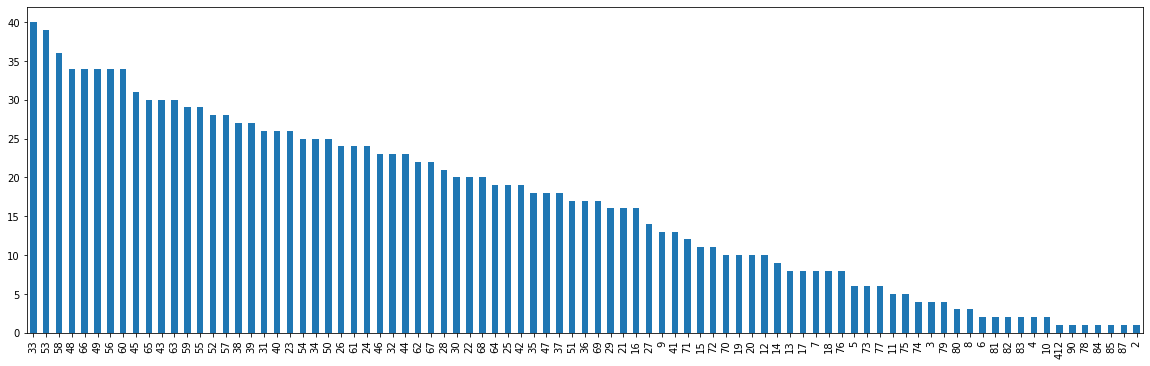

In [67]:
# Age distribution
plt.figure(figsize=(20,6))
data[data.Pneumonia ==1]['Patient Age'].value_counts().plot(kind='bar')


In [68]:
# Age Range
all_ages = data["Patient Age"].unique()
np.sort(all_ages)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95, 148, 149, 150, 151, 152, 153, 154, 155, 411,
       412, 413, 414])

In [69]:
# Age Range
all_ages = data[data.Pneumonia ==1]['Patient Age'].unique()
np.sort(all_ages)

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  87,  90, 412])

In [70]:
data.loc[data['Patient Age'] == 412]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,1,0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,1,0,0
91369,00022811_000.png,No Finding,0,22811,412,M,PA,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0


1. The age range is between 2 to 90 years for Pneumonia patients, ignoring one record which mentions 412 age.
2. The age range is between 1 to 95 years for all patients, ignoring records with age above 148 and above.

age distribution of all the records


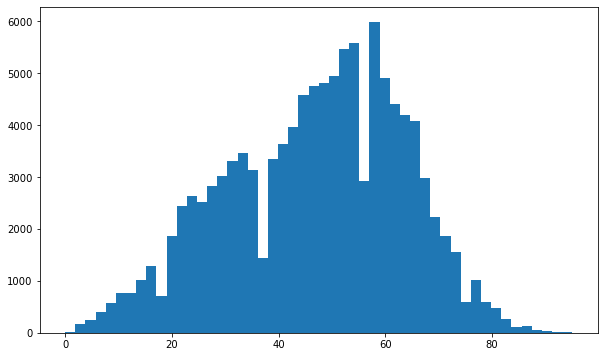

In [71]:
plt.figure(figsize=(10,6))
plt.hist(data['Patient Age'], range=(0, 95), bins=50)
print("age distribution of all the records")

age distribution of records with Pneumonia present


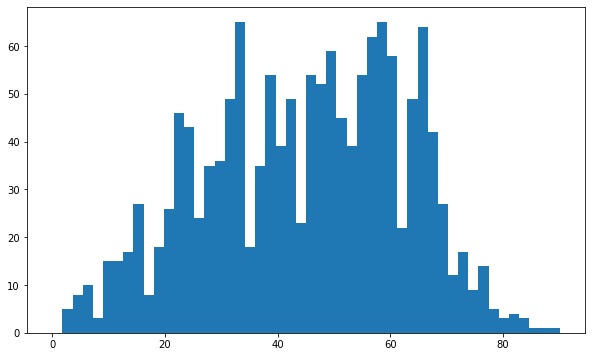

In [72]:
plt.figure(figsize=(10,6))
plt.hist(data[data.Pneumonia == 1]['Patient Age'], range=(0, 90), bins=50)
print("age distribution of records with Pneumonia present")

## Distribution of data (with Pneumonia) with respect to gender:

In [73]:
# Removing all records with age above 95, as the data is misguiding (goes from 148 to 414 years which is definately wrong)
index_names = data[ data['Patient Age'] > 95 ].index 
data.drop(index_names, inplace = True) 
all_ages = data["Patient Age"].unique()
np.sort(all_ages)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [78]:
print("Total Records left:", len(data))
# previous total records : 112120, now 112104. Total of 16 records removed

Total Records left: 112104


M    63328
F    48776
Name: Patient Gender, dtype: int64
Male Patient: 0.564904017697852
Female Patient: 0.435095982302148
difference: 0.129808035395704


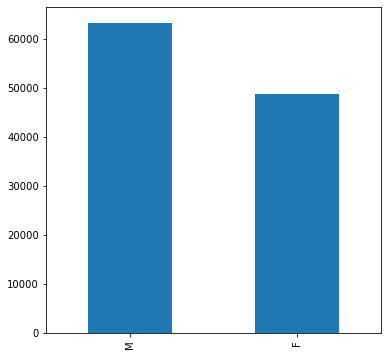

In [88]:
plt.figure(figsize=(6,6))
# data['Patient Gender'].value_counts().plot(kind='bar')
gender_records_all = data['Patient Gender'].value_counts()
gender_records_all.plot(kind='bar')
total_records = len(data)
print(gender_records_all)
print("Male Patient:", gender_records_all[0]/total_records)
print("Female Patient:", gender_records_all[1]/total_records)
print("difference:", gender_records_all[0]/total_records - gender_records_all[1]/total_records)


M    837
F    593
Name: Patient Gender, dtype: int64
Male Patient for Pneumonia: 0.5853146853146853
Female Patient  for Pneumonia: 0.41468531468531467
difference: 0.17062937062937067


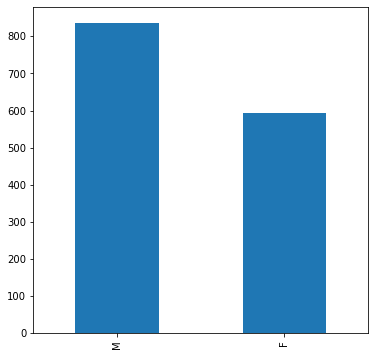

In [89]:
plt.figure(figsize=(6,6))
# data['Patient Gender'].value_counts().plot(kind='bar')
gender_records = data[data.Pneumonia == 1]['Patient Gender'].value_counts()
gender_records.plot(kind='bar')
total_gender_records = len(data[data.Pneumonia == 1])
print(gender_records)
print("Male Patient for Pneumonia:", gender_records[0]/total_gender_records)
print("Female Patient  for Pneumonia:", gender_records[1]/total_gender_records)
print("difference:", gender_records[0]/total_gender_records - gender_records[1]/total_gender_records)


## Distribution of data (with Pneumonia) with respect to View Position (patient position):

Position Records for all the data
PA    67299
AP    44805
Name: View Position, dtype: int64
PA : 0.6003264825519161
AP : 0.39967351744808394
difference: 0.20065296510383218


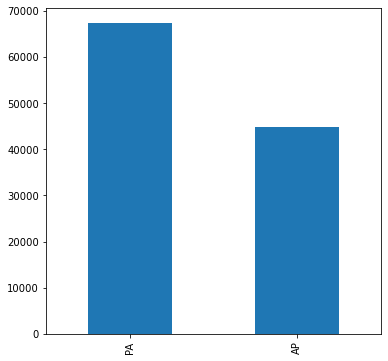

In [90]:
plt.figure(figsize=(6,6))
position_records = data['View Position'].value_counts()
position_records.plot(kind='bar')
print("Position Records for all the data")
print(position_records)
total_records = len(data['View Position'])
print("PA :", position_records[0]/total_records)
print("AP :", position_records[1]/total_records)
print("difference:", position_records[0]/total_records - position_records[1]/total_records)


Position Records for all the data
AP    800
PA    630
Name: View Position, dtype: int64
AP for Pneumonia: 0.5594405594405595
PA  for Pneumonia: 0.4405594405594406
difference: 0.11888111888111891


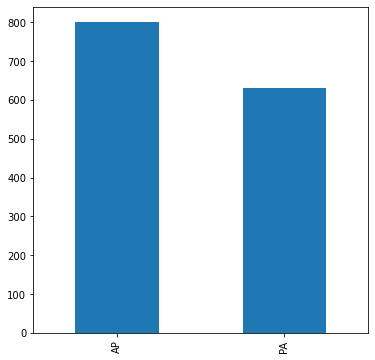

In [91]:
plt.figure(figsize=(6,6))
position_records = data[data.Pneumonia == 1]['View Position'].value_counts()
position_records.plot(kind='bar')
print("Position Records for all the data")
print(position_records)
total_records = len(data[data.Pneumonia == 1]['View Position'])
print("AP for Pneumonia:", position_records[0]/total_records)
print("PA  for Pneumonia:", position_records[1]/total_records)
print("difference:", position_records[0]/total_records - position_records[1]/total_records)


## Conclution, patient demographic data: 
We have removed all the records with age greater than 95 (as the age were coming in the higher range of 148 to 414 years)
#### Gender
The above two graphs show that there is difference of 12.98 percent in Male records to Female records, male records are 12.98 percent greater tham female records in the provided data set.

Also, at the same time the more male (17.06 percent) records are shown suffering form Pneumonia as compared to female records. 

#### Age:
Age is normally destributed as compared to records all records in comparion to Pneumonia records. There were some records which were giving wrong values of age from 148 years to 414 years, we have discarded those records

#### Patient Position while x ray was taken: 
It visible in the plotted data above that although the PA type x-ray records are more, but it is seen that more number of patients are found with x-ray taken in the AP position. This is because in AP view, the x-rays enter from front of the chest and captures lungs more effectively.



### Lets check the total number of images for each "Finding Label"

0.082%, 11558, Atelectasis
0.02%, 2776, Cardiomegaly
0.033%, 4667, Consolidation
0.016%, 2302, Edema
0.094%, 13316, Effusion
0.018%, 2516, Emphysema
0.012%, 1686, Fibrosis
0.002%, 227, Hernia
0.141%, 19891, Infiltration
0.041%, 5779, Mass
0.426%, 60353, No Finding
0.045%, 6331, Nodule
0.024%, 3384, Pleural_Thickening
0.01%, 1430, Pneumonia
0.037%, 5301, Pneumothorax
Total Records  112104


[Text(0, 0.5, 'Number of Images with Label')]

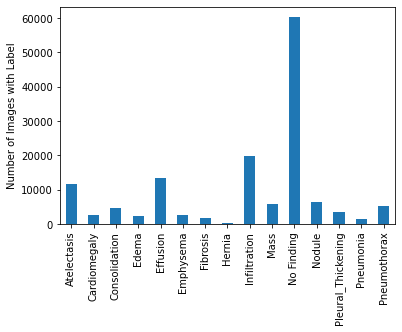

In [92]:
data_for_ax = data[all_labels].sum()

index = data_for_ax.index
a_list = list(index)
total = data_for_ax.sum()
for index, value in enumerate(data_for_ax):
    print(("{}%, {}, {}").format(round(value/total,3), data_for_ax[index], all_labels[index]))

print("Total Records ",len(data))

ax = data_for_ax.plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')


## Conclution, 
The number of cases including:
number of pneumonia cases,
number of non-pneumonia cases

As shown above, majority of the date is from "No Finding" roughtly 1% (1430 records out of total 112104 records) of records are labeled as "Pneumonia",



Lets look all this data in the order of number of records present along with "Pneumonia" (first 20 most frequent occurances): 
Distribution of other deseases with Pneumonia

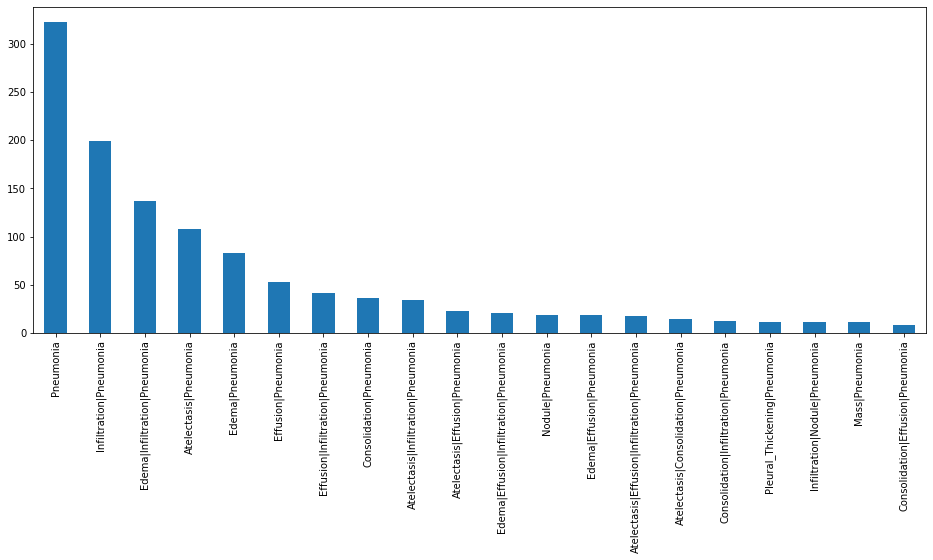

In [93]:
plt.figure(figsize=(16,6))
data[data.Pneumonia ==1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')

## Conclution, The distribution of other diseases that are combined with pneumonia

The above plot shows us that the most common co-occurance of "Pneumonia" is with "Infiltration", "Edema", "Atelectasis". These are some of the most common co-occurences

Number of disease per patient:

Number of deseases per patient


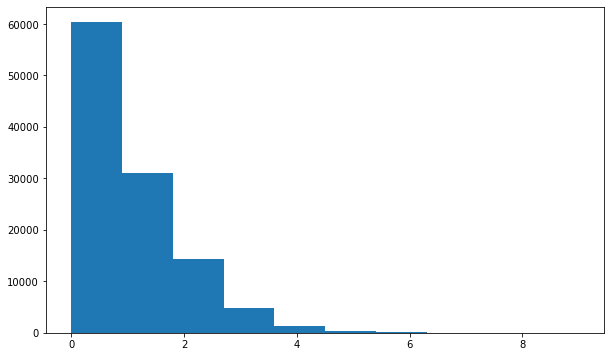

In [94]:
disease_lables = all_labels.copy()
disease_lables.remove("No Finding")
data['Disease Total Count'] = data.loc[:, disease_lables].sum(axis=1)
plt.figure(figsize=(10,6))
plt.hist(data['Disease Total Count'])
print("Number of deseases per patient")

Number of deseases per patient when Pneumonia is already present


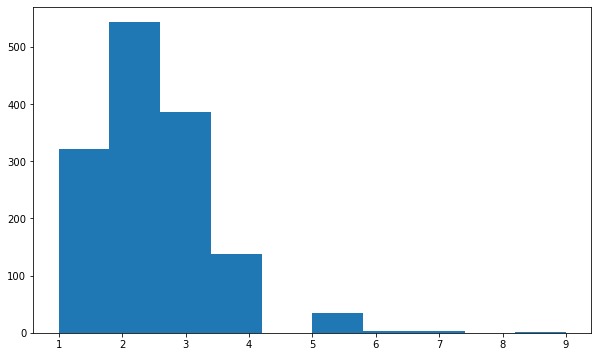

In [95]:
# disease_lables = all_labels.copy()
# disease_lables.remove("No Finding")
# data['Disease Total Count'] = data.loc[:, disease_lables].sum(axis=1)
plt.figure(figsize=(10,6))
plt.hist(data[data.Pneumonia==1]['Disease Total Count'])
print("Number of deseases per patient when Pneumonia is already present")

## Conclution, Number of disease per patient:
It is observed that Pneumonia is greater for all those patients who already have atleast 1 desease, 

Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

In [96]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
print(len(sample_df))
sample_df.head(10)

5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


In [97]:
def plot_hist(img, title):
    plt.figure(figsize=(6,6))
    plt.hist(img.ravel(), bins = 256,color='green')
    plt.legend([title])
    plt.show()
    
def standardise_img(img):
    return (img-np.mean(img))/np.std(img)

def plot_image(img):
    plt.imshow(img,cmap = "gray")

Intensity distribution of normal Image
No Finding


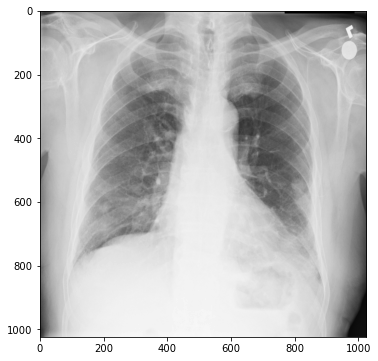

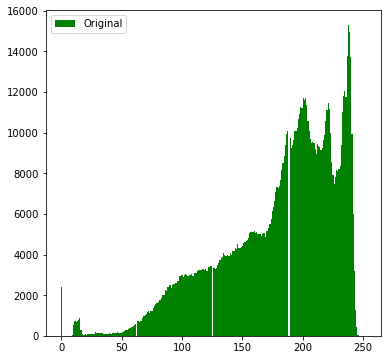

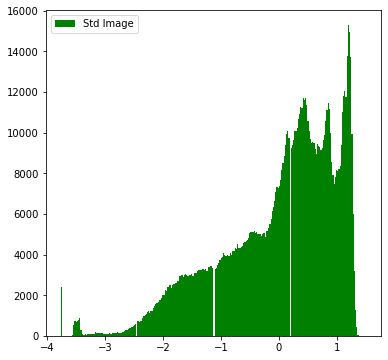

In [98]:
print("Intensity distribution of normal Image")
img_dcm = pydicom.dcmread("test1.dcm")
print(img_dcm.StudyDescription)

plt.figure(figsize=(6,6))
plot_image(img_dcm.pixel_array)
plot_hist(img_dcm.pixel_array, "Original")
std_img = standardise_img(img_dcm.pixel_array)
plot_hist(std_img, "Std Image")

Intensity distribution of Cardiomegaly Image
Cardiomegaly


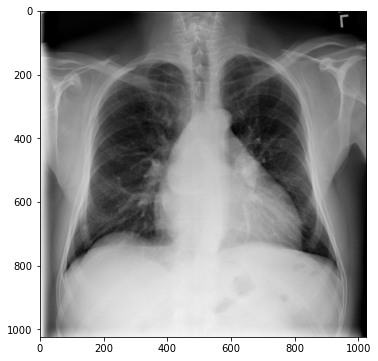

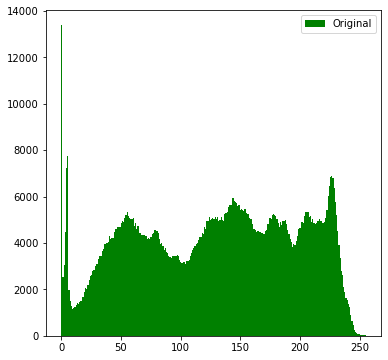

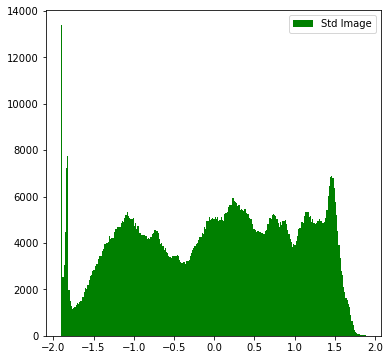

In [99]:
print("Intensity distribution of Cardiomegaly Image")
img_dcm = pydicom.dcmread("test2.dcm")
print(img_dcm.StudyDescription)

plt.figure(figsize=(6,6))
plot_image(img_dcm.pixel_array)
plot_hist(img_dcm.pixel_array, "Original")
std_img = standardise_img(img_dcm.pixel_array)
plot_hist(std_img, "Std Image")

Intensity distribution of Effusion Image
Effusion


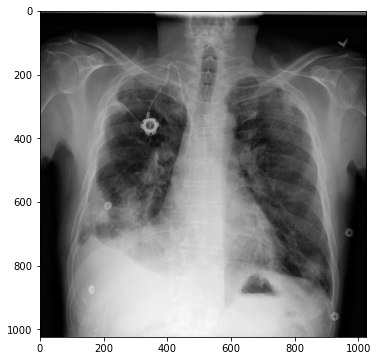

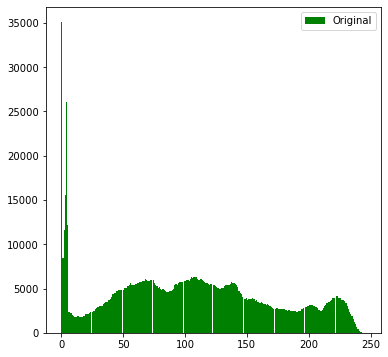

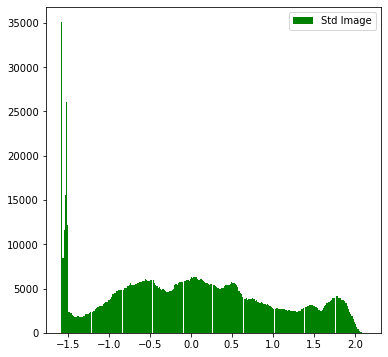

In [100]:
print("Intensity distribution of Effusion Image")
img_dcm = pydicom.dcmread("test3.dcm")
print(img_dcm.StudyDescription)

plt.figure(figsize=(6,6))
plot_image(img_dcm.pixel_array)
plot_hist(img_dcm.pixel_array, "Original")
std_img = standardise_img(img_dcm.pixel_array)
plot_hist(std_img, "Std Image")

Image Index 00008470_008.png
Image Index 00011702_043.png
Image Index 00012158_025.png
Image Index 00012667_000.png
Image Index 00012733_000.png
Image Index 00014201_008.png
Image Index 00017714_019.png
Image Index 00019021_001.png
Image Index 00019865_013.png
Image Index 00021127_018.png


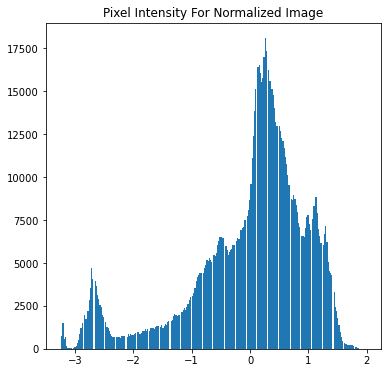

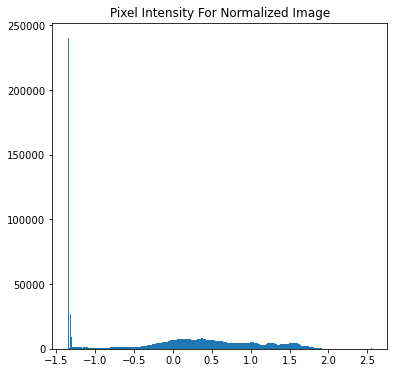

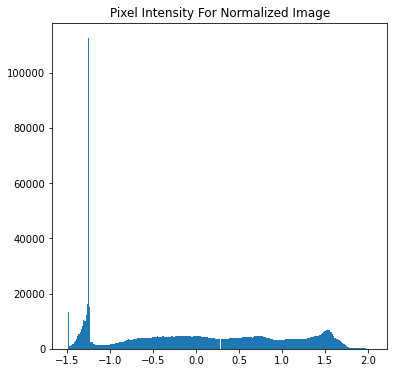

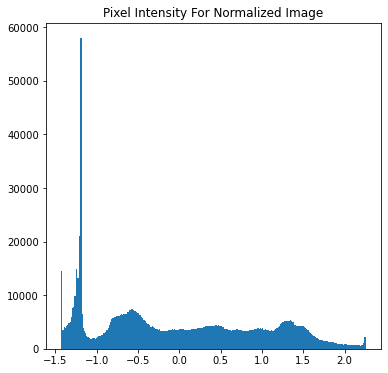

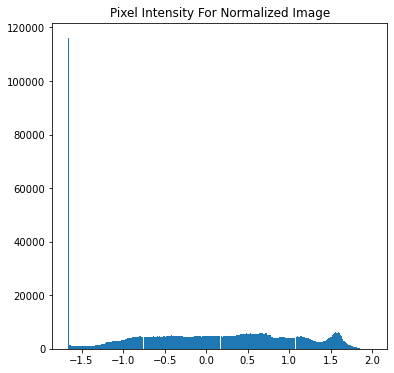

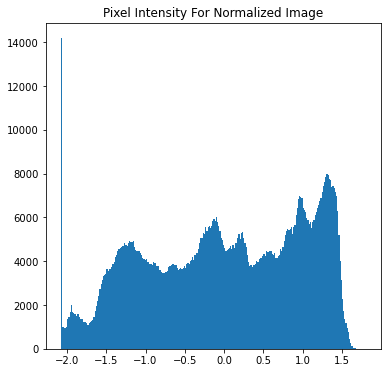

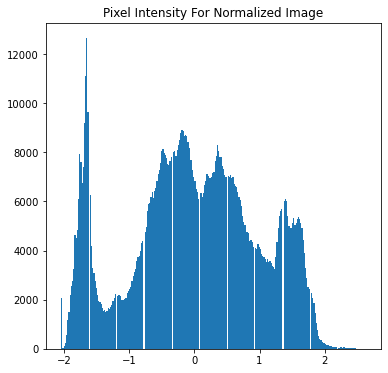

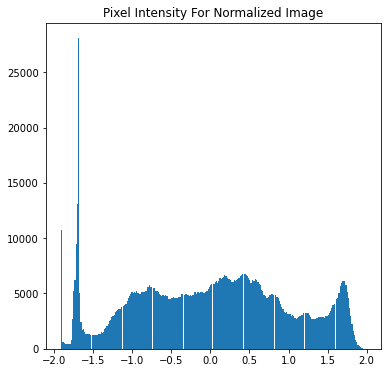

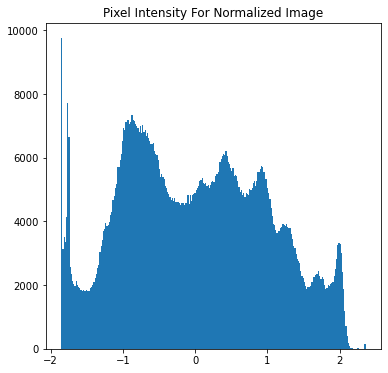

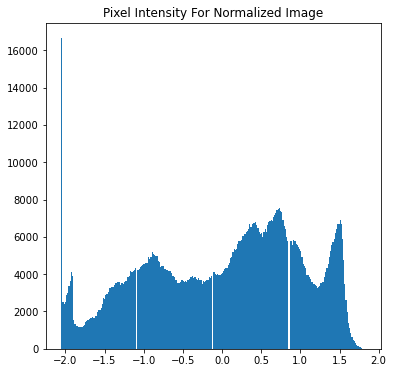

In [103]:
bbox = pd.read_csv('/data/BBox_List_2017.csv')
data_pneumonia = sample_df[sample_df['Finding Labels'] == "Pneumonia"]

import os
def find_file(img):
    file_loc = {}
    for dirs,subdirs, files in os.walk('/data/'):
        for file in files:
            file_loc[file] = os.path.join(dirs, file)
    return file_loc[img]

for i in range(10):
    img = Image.open(find_file(data_pneumonia["Image Index"].iloc[i]))
    print("Image Index", data_pneumonia["Image Index"].iloc[i])
    pixels = np.array(img.getdata())
    mean_intensity = np.mean(pixels)
    std_intensity = np.std(pixels)
    new_img = pixels.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    plt.figure(figsize=(6,6))
    plt.hist(new_img.ravel(), bins = 256)
    plt.title('Pixel Intensity For Normalized Image')


Image Index 00000017_001.png
Image Index 00000042_002.png
Image Index 00000057_001.png
Image Index 00000061_019.png
Image Index 00000080_005.png
Image Index 00000083_000.png
Image Index 00000099_006.png
Image Index 00000121_004.png
Image Index 00000165_008.png
Image Index 00000188_001.png


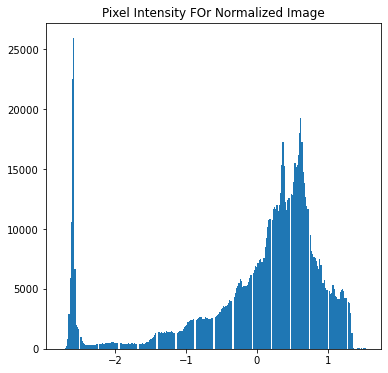

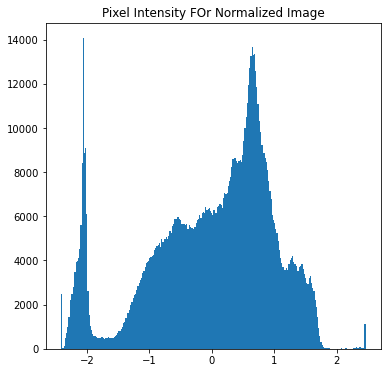

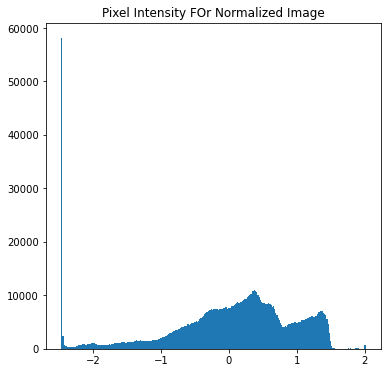

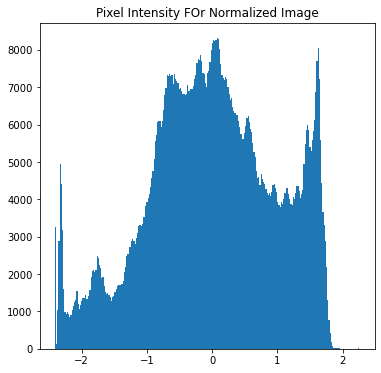

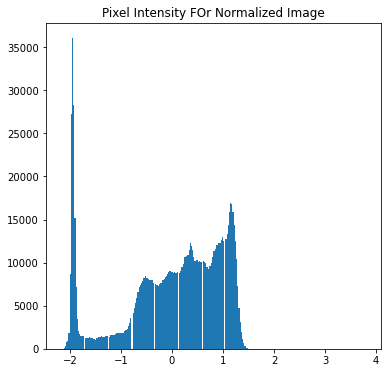

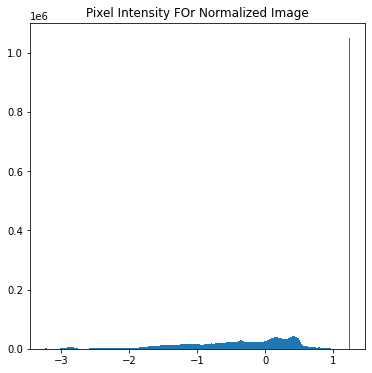

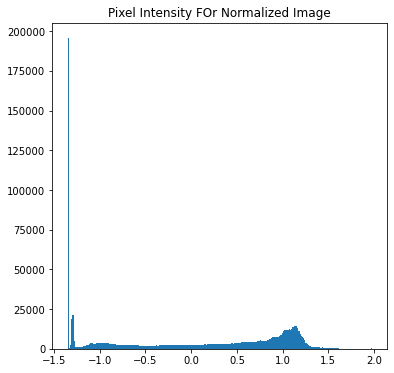

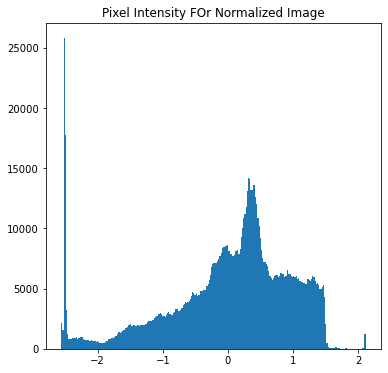

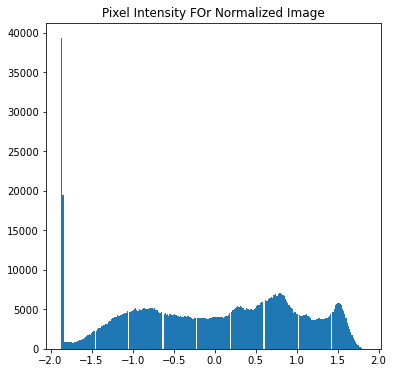

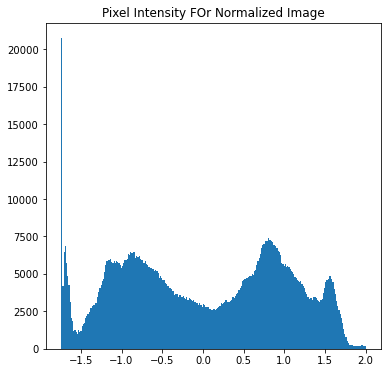

In [104]:
data_no_pneumonia = sample_df[sample_df['Finding Labels'] == "No Finding"]
for i in range(10):
    img = Image.open(find_file(data_no_pneumonia["Image Index"].iloc[i]))
    print("Image Index", data_no_pneumonia["Image Index"].iloc[i])
    pixels = np.array(img.getdata())
    mean_intensity = np.mean(pixels)
    std_intensity = np.std(pixels)
    new_img = pixels.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    plt.figure(figsize=(6,6))
    plt.hist(new_img.ravel(), bins = 256)
    plt.title('Pixel Intensity FOr Normalized Image')

## Conclusion:

1. In the above two cases we have seen the intensity distribution and the normalised intensity distribution, we notice that just after (0,0), the intensity attains as momentary peak this is because of the black border of the X-ray image.

2. Other thing we notice that health lung has less obstruction for the x-ray so it is more black, but the ohe lung with the dease has less of air and more of ther mass so the x-ray film shows a lighter part in that area. 

3. Also as we have seen the intensity distribution is some what distrbuted throughout. It is hard to find out the (differentiate) an unhealthy lung from healthy lung as different lungs may have different levels of intensity based on the nodules or other patches position.
